In [31]:
# global configuration variables
dbFilename = r"splice-folder.db"

# source folder for archive files
siblingSourceFolder = "corpus"

In [32]:
import essentia
from essentia import Pool, array
import essentia.streaming as ess
import essentia.standard as stan
from pylab import *
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import Audio

## SQLite interface

In [33]:
import sqlite3
from sqlite3 import Error


def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
#     try:
    conn = sqlite3.connect(db_file)
    print(sqlite3.version)
    return conn
#     except Error as e:
#         print(e)
        
def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def create_archive_file(conn, archive_file):
    """
    Create a new archive_file into the archive_file table
    :param conn:
    :param archive_file:
    :return: project id
    """
    sql = ''' INSERT INTO archive_files(name, durationSeconds)
              VALUES(?,?) '''
    cur = conn.cursor()
    cur.execute(sql, archive_file)
    conn.commit()
    return cur.lastrowid

def create_sound_object(conn, sound_object):
    """
    Create a new sound_object
    :param conn:
    :param sound_object:
    :return: sound_object id
    """

    sql = ''' INSERT INTO sound_objects(durationSeconds,effectiveDuration,rms,loudness,pitch,pitchConfidence,flatness,centroid,variance,path,archive_file_id,archive_file_duration_seconds,start,end)
              VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, sound_object)
    conn.commit()

    return cur.lastrowid

def create_descriptor_stats(conn, stats):
    """
    Create a new task
    :param conn:
    :param stats:
    :return: stats id
    """

    sql = ''' INSERT INTO stats(descriptor, avg, stddev, min, max)
              VALUES(?,?,?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, stats)
    conn.commit()

    return cur.lastrowid

def update_stats(conn, stats):
    sql = ''' UPDATE stats
              SET descriptor = ?
              WHERE id = ?'''
    cur = conn.cursor()
    cur.execute(sql, stats)
    conn.commit()

def delete_stats(conn):
    """
    Delete stats records
    :param conn:
    """

    sql = ''' DELETE FROM stats '''
    cur = conn.cursor()
    cur.execute(sql)
    conn.commit()

## SQLite user-defined functions

In [34]:
import sqlite3
import math

def create_stats(descriptorName,avg,stddev,descriptorMin,descriptorMax):
    statsRecord = (
        descriptorName,
        avg,
        stddev,
        descriptorMin,
        descriptorMax
    )
    return create_descriptor_stats(db, statsRecord)

# https://www.alexforencich.com/wiki/en/scripts/python/stdev
class StdevFunc:
    def __init__(self):
        self.M = 0.0
        self.S = 0.0
        self.k = 1
 
    def step(self, value):
        if value is None:
            return
        tM = self.M
        self.M += (value - tM) / self.k
        self.S += (value - tM) * (value - self.M)
        self.k += 1
 
    def finalize(self):
        if self.k < 3:
            return None
        return math.sqrt(self.S / (self.k-2))
    
class HistogramFunc:
    def __init__(self):
        self.d = np.empty(1)

    def step(self, value):
        self.d = np.append(self.d, value)
 
    def finalize(self):
        self.d = np.delete(self.d, 0)
        
        stddev = np.std(self.d)
        mean = np.mean(self.d)
        descMin = np.amin(self.d)
        descMax = np.amax(self.d)

        print("mean, std")
        print(mean)
        print(stddev)
        
        print("min")
        print(descMin)
        print(np.argmin(self.d))

        
        print("max")
        print(descMax)
        print(np.argmax(self.d))

        range_low = mean - 2*stddev;
        range_high = mean + 2*stddev;
        if range_low < 0:
            range_low = 0
        range_tuple = (range_low,range_high)
        print(range_tuple)

        plt.hist(self.d, bins = 40, range = range_tuple) 
        plt.title("Histogram") 
        plt.show()
        
        stats_id = create_stats("name", mean, stddev, descMin, descMax)
        
        return stats_id


## Create database and tables

In [35]:
db = create_connection(dbFilename)

sql_create_stats_table = """ CREATE TABLE stats (
                                    id integer PRIMARY KEY,
                                    descriptor text NOT NULL,
                                    avg float NOT NULL,
                                    stddev float NOT NULL,
                                    min float NOT NULL,
                                    max float NOT NULL
                                ); """

sql_create_archive_files_table = """ CREATE TABLE archive_files (
                                    id integer PRIMARY KEY,
                                    name text NOT NULL,
                                    durationSeconds float NOT NULL
                                ); """

sql_create_sound_objects_table = """CREATE TABLE sound_objects (
                                    id integer PRIMARY KEY,
                                    durationSeconds float NOT NULL,
                                    effectiveDuration float NOT NULL,
                                    rms float NOT NULL,
                                    loudness float NOT NULL,
                                    pitch float NOT NULL,
                                    pitchConfidence float NOT NULL,
                                    flatness float NOT NULL,
                                    centroid float NOT NULL,
                                    variance float NOT NULL,
                                    path text NOT NULL,
                                    archive_file_id integer NOT NULL,
                                    archive_file_duration_seconds float NOT NULL,
                                    start integer NOT NULL,
                                    end integer NOT NULL,
                                    FOREIGN KEY (archive_file_id) REFERENCES archive_files (id)
                                );"""

# create tables
if db is not None:
    # create stats table
    create_table(db, sql_create_stats_table)
    
    # create archive_files table
    create_table(db, sql_create_archive_files_table)

    # create sound_objects table
    create_table(db, sql_create_sound_objects_table)
else:
    print("Error! cannot create the database connection.")

2.6.0
table stats already exists
table archive_files already exists
table sound_objects already exists


In [36]:
def get_sound_objects_from_onsets(onset_positions, audio):

    sound_objects = []
    skipped = 0
    numOnsets = onset_positions.shape[0]
    if numOnsets == 1:
        return sound_objects;
    for i in range(numOnsets):
        if i == 0:
            continue

        nStart = int(sampleRate * onset_positions[i-1]) # previous onset sample
        nEnd = int(sampleRate * onset_positions[i]) # current onset sample

        if(nEnd-nStart) < sampleRate*0.15: # remove sounds that are shorter than 0.15 seconds
            continue
        if(nEnd-nStart) > sampleRate*10: # filter sounds that are longer than 10
            continue

        startFrame = int(nStart/hopSize) # loss of precision here
        endFrame = int(nEnd/hopSize)

        sound_object_data = {}
        sound_object_data["rms"] = stan.Mean()(pool["features.rms"][startFrame:endFrame])
        
        sound_object_data["loudness"] = stan.Mean()(pool["features.loudness"][startFrame:endFrame])

        #print("mean rms: " + str(stan.Mean()(pool["features.rms"][startFrame:endFrame])))
        #print("weighted rms: " + str(sound_object_data["rms"]))
             
        sound_object_data["flatness"] = energy_weighted_mean(pool["features.flatnessDB"], startFrame, endFrame)
        
        weighted_mean_centroid = energy_weighted_mean(pool["features.centroid"], startFrame, endFrame)
        centroid_frequency = weighted_mean_centroid * (sampleRate/2)
        centroid_mel = 1000 * math.log2(1 + centroid_frequency/1000)
        sound_object_data["centroid"] = centroid_mel
        
        sound_object_data["variance"] = energy_weighted_mean(pool["features.variance"], startFrame, endFrame)

        pitch_freq = pitch_confidence_weighted_mean(pool["features.pitch"], startFrame, endFrame)
        if pitch_freq < 1:
            pitch_freq = 0
        sound_object_data["pitch"] = 1000 * math.log2(1 + pitch_freq/1000)
        #print("mean pitch: " + str(stan.Mean()(pool["features.pitch"][startFrame:endFrame])))
        #print("weighted pitch: " + str(sound_object_data["pitch"]))
        
        sound_object_data["pitchConfidence"] = energy_weighted_mean(pool["features.pitchConfidence"], startFrame, endFrame)
        
        sound_object_data["audio"] = audio[nStart:nEnd]
        sound_object_data["start"] = nStart
        sound_object_data["end"] = nEnd
        
        if(nStart > len(audio)):
            skipped = skipped + 1
            continue

        sound_objects.append(sound_object_data)

    return sound_objects

def energy_weighted_mean(feature_vector, startFrame, endFrame):
    weights = pool["features.energy"][startFrame : endFrame]
    weighted_feature = feature_vector[startFrame : endFrame] * weights
    weighted_feature_sum = np.sum(weighted_feature)
    
    return float(weighted_feature_sum / np.sum(weights))

def pitch_confidence_weighted_mean(feature_vector, startFrame, endFrame):
    weights = pool["features.pitchConfidence"][startFrame : endFrame]
    weighted_feature = feature_vector[startFrame : endFrame] * weights
    weighted_feature_sum = np.sum(weighted_feature)
    
    return float(weighted_feature_sum / np.sum(weights))
    

In [37]:
# putting it all together
from pathlib import Path
from scipy.io.wavfile import write, read
import json

def write_archive_file_sound_objects_to_db(archive_file_path, sound_objects, archive_file_duration_in_seconds):
    # initialize an object to store data for the clip
    sourcePath = Path(archive_file_path) # create the source path
    path_relative_to_db_file = str("/".join(sourcePath.parts[2::]))
    
    archive_file = (path_relative_to_db_file, archive_file_duration_in_seconds,)
    archive_file_id = create_archive_file(db, archive_file)

    # process each detected sound_object
    for i, sound_object in enumerate(sound_objects):
        durationSeconds = len(sound_object["audio"]) / sampleRate
        
        effectiveDuration = stan.EffectiveDuration()(sound_object["audio"])
        
        sound_object_attributes = (
            durationSeconds,
            effectiveDuration,
            sound_object["rms"],
            sound_object["loudness"],
            sound_object["pitch"],
            sound_object["pitchConfidence"],
            sound_object["flatness"],
            sound_object["centroid"],
            sound_object["variance"],
            path_relative_to_db_file,
            archive_file_id,
            archive_file_duration_in_seconds,
            sound_object["start"],
            sound_object["end"]
        )

        create_sound_object(db, sound_object_attributes)

In [38]:
from pathlib import Path

def already_processed(archive_file_path):
    
    sourcePath = Path(archive_file_path) # create the source path
    path_relative_to_db_file = str("/".join(sourcePath.parts[2::]))
    
    cursor = db.cursor()
    rowsQuery = "SELECT Count(*) FROM archive_files where name = \"" + path_relative_to_db_file + "\";"
    cursor.execute(rowsQuery)
    return cursor.fetchone()[0] > 0

In [39]:
from datetime import datetime
import os
import traceback

print("Loading extractor...")

count = 0;

standardLoader = stan.MonoLoader()
streamingLoader = ess.MonoLoader()

sampleRate=44100
frameSize=2048
hopSize=512

framecutter = ess.FrameCutter(frameSize=frameSize, hopSize=hopSize, silentFrames='noise')
windowing = ess.Windowing(type='hann')
c2p = ess.CartesianToPolar()
od1 = ess.OnsetDetection(method='hfc')
fft = ess.FFT()
pitch = ess.PitchYinFFT(frameSize=frameSize)
rms = ess.RMS()
loudness = ess.Loudness()
flatness = ess.FlatnessDB()
centroid = ess.Centroid()
variance = ess.Variance()
spectrum = ess.Spectrum()
energy = ess.Energy()
pool = Pool()

# Connect streaming algorithms
streamingLoader.audio >> framecutter.signal
framecutter.frame >> windowing.frame >> fft.frame
fft.fft >> c2p.complex
c2p.phase >> od1.phase
c2p.magnitude >> None

windowing.frame >> energy.array
energy.energy >> (pool, 'features.energy')

windowing.frame >> spectrum.frame
spectrum.spectrum >> od1.spectrum
od1.onsetDetection >> (pool, 'features.hfc')

windowing.frame >> rms.array
rms.rms >> (pool, 'features.rms')

windowing.frame >> loudness.signal
loudness.loudness >> (pool, 'features.loudness')

spectrum.spectrum >> pitch.spectrum
pitch.pitch >> (pool, 'features.pitch')
pitch.pitchConfidence >> (pool, 'features.pitchConfidence')

c2p.magnitude >> flatness.array
flatness.flatnessDB >> (pool, 'features.flatnessDB')

c2p.magnitude >> centroid.array
centroid.centroid >> (pool, 'features.centroid')

c2p.magnitude >> variance.array
variance.variance >> (pool, 'features.variance')

recursive_list = [os.path.join(dp, f) for dp, dn, fn in os.walk(os.getcwd() + "/" + siblingSourceFolder) for f in fn]
print("... recursive walk found %i files ..." % len(recursive_list))

for archive_file_path in recursive_list:
    if (archive_file_path.endswith((".wav",".m4a",".aiff",".mp3",".aif",))):
        if already_processed(archive_file_path):
            print(str(count) + ": " + archive_file_path + " -- already processed, skipping")
            count = count + 1
            continue
            
        try:
            standardLoader.configure(filename=archive_file_path)
            audio = standardLoader()
            streamingLoader.configure(filename=archive_file_path)
        except:
            formatted_exception = traceback.format_exc()
            print("some error occured on %s" % archive_file_path)
            print(formatted_exception)
            continue
        
        count = count + 1
        essentia.run(streamingLoader)

        # Phase 2: compute the actual onsets locations
        
        # NOTE This implementation depends on a frameRate of 44100.0/512.0
        onsets = stan.Onsets(frameRate=sampleRate/hopSize)

        onsets_hfc = onsets(# this algo expects a matrix, not a vector
            array([ pool['features.hfc'] ]),
            # you need to specify weights, but as there is only a single
            # function, it doesn't actually matter which weight you give it
            [ 1 ])
        
        sound_objects = get_sound_objects_from_onsets(onsets_hfc, audio)
        
        archive_file_duration_in_seconds = len(audio)/sampleRate
        write_archive_file_sound_objects_to_db(archive_file_path, sound_objects, archive_file_duration_in_seconds)
        
        print(str(count) + ": " + archive_file_path + " ✅ " + str(len(sound_objects)) + " sound objects")

        
        # clear pool for next run
        pool.clear()
        # flush the audio buffer variable
        del audio



Loading extractor...
... recursive walk found 5144 files ...
0: /notebooks/corpus/100 - doo Project/Samples/Recorded/6-Audio 0001 [2020-03-27 204310].aif -- already processed, skipping
1: /notebooks/corpus/100 - doo Project/Samples/Recorded/6-Audio 0002 [2020-03-27 204312].aif -- already processed, skipping
2: /notebooks/corpus/100 - doo Project/Samples/Recorded/6-Audio 0003 [2020-03-27 204606].aif -- already processed, skipping
3: /notebooks/corpus/100 - doo Project/Samples/Recorded/6-Audio 0004 [2020-03-27 204935].aif -- already processed, skipping
4: /notebooks/corpus/100 - doo Project/Samples/Recorded/6-Audio 0005 [2020-03-27 205246].aif -- already processed, skipping
5: /notebooks/corpus/100 - doo Project/Samples/Recorded/6-Audio 0006 [2020-03-29 013452].aif -- already processed, skipping
6: /notebooks/corpus/100 - doo Project/Samples/Recorded/6-Audio 0007 [2020-03-29 013924].aif -- already processed, skipping
7: /notebooks/corpus/100 - doo Project/Samples/Recorded/6-Audio 0008 [2

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/FLOOR_TOM_PL_1816_finger 5.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioLoader: Could not open file "/notebooks/corpus/100 - doo Project/Samples/splice/FLOOR_TOM_PL_1816_finger 5.aif", error = Operation not permitted

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/FLOOR_TOM_PL_1816_finger 6.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuri

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/FLOOR_TOM_SR_1614_finger 16.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioLoader: Could not open file "/notebooks/corpus/100 - doo Project/Samples/splice/FLOOR_TOM_SR_1614_finger 16.aif", error = Operation not permitted

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/FLOOR_TOM_SR_1614_finger 18.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while config

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/HIHAT_PE_TL_14_pedal#2 13.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioLoader: Could not open file "/notebooks/corpus/100 - doo Project/Samples/splice/HIHAT_PE_TL_14_pedal#2 13.aif", error = Operation not permitted

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/HIHAT_PE_TL_14_pedal#2 16.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring 

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/HIHAT_PE_TW_15_closed_side_tight 6.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioLoader: Could not open file "/notebooks/corpus/100 - doo Project/Samples/splice/HIHAT_PE_TW_15_closed_side_tight 6.aif", error = Operation not permitted

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/HIHAT_PE_TW_15_closed_side_tight 7.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeErro

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/HIHAT_PE_TW_15_closed_tip_tight7.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioLoader: Could not open file "/notebooks/corpus/100 - doo Project/Samples/splice/HIHAT_PE_TW_15_closed_tip_tight7.aif", error = Operation not permitted

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/HIHAT_PE_TW_15_closed_tip_tight9.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Err

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/HIHAT_PE_TW_15_loose_tip 21.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioLoader: Could not open file "/notebooks/corpus/100 - doo Project/Samples/splice/HIHAT_PE_TW_15_loose_tip 21.aif", error = Operation not permitted

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/HIHAT_PE_TW_15_loose_tip 23.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while config

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/KICK Drum Case - 41.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioLoader: Could not open file "/notebooks/corpus/100 - doo Project/Samples/splice/KICK Drum Case - 41.aif", error = Operation not permitted

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/KICK Drum Case - 43.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioL

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/KICK_ROTO_18 14.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioLoader: Could not open file "/notebooks/corpus/100 - doo Project/Samples/splice/KICK_ROTO_18 14.aif", error = Operation not permitted

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/KICK_ROTO_18 5.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioLoader: Could 

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/RIDE_PE_TW_22_cup_tip 8.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioLoader: Could not open file "/notebooks/corpus/100 - doo Project/Samples/splice/RIDE_PE_TW_22_cup_tip 8.aif", error = Operation not permitted

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/RIDE_PE_TW_22_cup_tip 9.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLo

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/SNARE_MX_1335_BRS_SFX 115.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioLoader: Could not open file "/notebooks/corpus/100 - doo Project/Samples/splice/SNARE_MX_1335_BRS_SFX 115.aif", error = Operation not permitted

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/SNARE_MX_1455_STL_open_stick_side stick 10.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error w

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/SNARE_PL_1435_BRS_Low_stick_off center 19.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioLoader: Could not open file "/notebooks/corpus/100 - doo Project/Samples/splice/SNARE_PL_1435_BRS_Low_stick_off center 19.aif", error = Operation not permitted

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/SNARE_PL_1435_BRS_Low_stick_off center 2.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(*

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/SNARE_TS_1465_CBN_SFX 44.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioLoader: Could not open file "/notebooks/corpus/100 - doo Project/Samples/splice/SNARE_TS_1465_CBN_SFX 44.aif", error = Operation not permitted

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/SNARE_TS_1465_CBN_SFX 50.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring Mon

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/SPLASH_PE_TW_10_edge_crash 5.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioLoader: Could not open file "/notebooks/corpus/100 - doo Project/Samples/splice/SPLASH_PE_TW_10_edge_crash 5.aif", error = Operation not permitted

some error occured on /notebooks/corpus/100 - doo Project/Samples/splice/SPLASH_PE_TW_10_edge_crash 6.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while con

58: /notebooks/corpus/104 - Mark Hirsch - Rome Project/Samples/splice/prophet (reference) 0012 [2020-02-09 183227].aif -- already processed, skipping
59: /notebooks/corpus/104 - Mark Hirsch - Rome Project/Samples/splice/prophet (reference) 0016 [2020-02-09 184311].aif -- already processed, skipping
60: /notebooks/corpus/104 - Mark Hirsch - Rome Project/Samples/splice/prophet (reference) 0017 [2020-02-09 184346].aif -- already processed, skipping
61: /notebooks/corpus/104 - Mark Hirsch - Rome Project/Samples/splice/prophet (reference) 0019 [2020-02-09 185058].aif -- already processed, skipping
62: /notebooks/corpus/104 - Mark Hirsch - Rome Project/Samples/splice/prophet (reference) 0021 [2020-02-09 185338].aif -- already processed, skipping
63: /notebooks/corpus/104 - Mark Hirsch - Rome Project/Samples/splice/rome_drms_kit1.aif -- already processed, skipping
64: /notebooks/corpus/104 - Mark Hirsch - Rome Project/Samples/splice/rome_drms_kit2.aif -- already processed, skipping
65: /noteb

123: /notebooks/corpus/122 - obs-2 whistle-piano Project/Samples/Recorded/2-Audio 0002 [2021-05-17 012133].aif -- already processed, skipping
124: /notebooks/corpus/122 - obs-2 whistle-piano Project/Samples/Recorded/2-Audio 0003 [2021-05-08 003739].aif -- already processed, skipping
125: /notebooks/corpus/122 - obs-2 whistle-piano Project/Samples/Recorded/2-Audio 0004 [2021-05-08 003906].aif -- already processed, skipping
126: /notebooks/corpus/122 - obs-2 whistle-piano Project/Samples/Recorded/2-Audio 0004 [2021-05-17 034052].aif -- already processed, skipping
127: /notebooks/corpus/122 - obs-2 whistle-piano Project/Samples/Recorded/2-Audio 0004 [2021-05-17 034059].aif -- already processed, skipping
128: /notebooks/corpus/122 - obs-2 whistle-piano Project/Samples/Recorded/2-Audio 0005 [2021-05-08 004702].aif -- already processed, skipping
129: /notebooks/corpus/122 - obs-2 whistle-piano Project/Samples/Recorded/2-Audio 0006 [2021-05-08 005251].aif -- already processed, skipping
130: /

220: /notebooks/corpus/130 - collage for babybaby song Project/Samples/Recorded/2-Audio 0001 [2021-06-21 153843].aif ✅ 42 sound objects
221: /notebooks/corpus/130 - collage for babybaby song Project/Samples/Recorded/2-Audio 0001 [2021-06-21 154512].aif ✅ 33 sound objects
221: /notebooks/corpus/130 - collage for babybaby song Project/Samples/Recorded/2-Audio 0002 [2021-06-18 224513].aif -- already processed, skipping
222: /notebooks/corpus/130 - collage for babybaby song Project/Samples/Recorded/2-Audio 0003 [2021-06-18 224516].aif -- already processed, skipping
223: /notebooks/corpus/130 - collage for babybaby song Project/Samples/Recorded/2-Audio 0004 [2021-06-18 225011].aif -- already processed, skipping
224: /notebooks/corpus/130 - collage for babybaby song Project/Samples/Recorded/2-Audio 0005 [2021-06-18 225354].aif -- already processed, skipping
225: /notebooks/corpus/130 - collage for babybaby song Project/Samples/Recorded/2-Audio 0006 [2021-06-18 225715].aif -- already processe

286: /notebooks/corpus/145 - sound-palette-corpus demo3 Project/Samples/Recorded/4-Audio 0008 [2021-04-01 164008].aif -- already processed, skipping
some error occured on /notebooks/corpus/145 - sound-palette-corpus demo3 Project/Samples/Recorded/4-Audio 0009 [2021-04-01 184814].aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioLoader: Could not open file "/notebooks/corpus/145 - sound-palette-corpus demo3 Project/Samples/Recorded/4-Audio 0009 [2021-04-01 184814].aif", error = Invalid data found when processing input

287: /notebooks/corpus/145 - sound-palette-corpus demo3 Project/Samples/Recorded/6-Audio 0001 [2021-04-01 163941].aif -- already processed, skipping
288: /notebooks/corpus/145 - sound-palet

363: /notebooks/corpus/58 - Nathaly - How do I act content Project/Samples/Recorded/2-Audio 0002 [2021-04-23 131150].aif -- already processed, skipping
364: /notebooks/corpus/58 - Nathaly - How do I act content Project/Samples/Recorded/2-Audio 0003 [2021-04-23 131214].aif -- already processed, skipping
365: /notebooks/corpus/58 - Nathaly - How do I act content Project/Samples/Recorded/2-Audio 0004 [2021-04-23 131232].aif -- already processed, skipping
366: /notebooks/corpus/58 - Nathaly - How do I act content Project/Samples/Recorded/2-Audio 0005 [2021-04-23 131241].aif -- already processed, skipping
367: /notebooks/corpus/58 - Nathaly - How do I act content Project/Samples/Recorded/2-Audio 0006 [2021-04-23 131249].aif -- already processed, skipping
368: /notebooks/corpus/58 - Nathaly - How do I act content Project/Samples/Recorded/2-Audio 0007 [2021-04-23 131257].aif -- already processed, skipping
369: /notebooks/corpus/58 - Nathaly - How do I act content Project/Samples/Recorded/2-Au

457: /notebooks/corpus/76 - nickjams - coming home Project/Samples/splice/0002 10-Audio.aif -- already processed, skipping
458: /notebooks/corpus/76 - nickjams - coming home Project/Samples/splice/0003 10-Audio.aif -- already processed, skipping
459: /notebooks/corpus/76 - nickjams - coming home Project/Samples/splice/AmpViolin Kick2.wav -- already processed, skipping
460: /notebooks/corpus/76 - nickjams - coming home Project/Samples/splice/Bridge Vox 1_1.wav -- already processed, skipping
461: /notebooks/corpus/76 - nickjams - coming home Project/Samples/splice/Bridge Vox 2_1.wav -- already processed, skipping
462: /notebooks/corpus/76 - nickjams - coming home Project/Samples/splice/Bridge Vox high2_1.wav -- already processed, skipping
463: /notebooks/corpus/76 - nickjams - coming home Project/Samples/splice/Bridge vox high1_1.wav -- already processed, skipping
464: /notebooks/corpus/76 - nickjams - coming home Project/Samples/splice/CATCHY SYN Hat Loop 78.wav -- already processed, sk

525: /notebooks/corpus/76 - nickjams - coming home Project/Samples/splice/perc 2.aiff -- already processed, skipping
526: /notebooks/corpus/76 - nickjams - coming home Project/Samples/splice/sd6.wav -- already processed, skipping
527: /notebooks/corpus/76 - nickjams - coming home Project/Samples/splice/sd7_echo.wav -- already processed, skipping
528: /notebooks/corpus/76 - nickjams - coming home Project/Samples/splice/snare 1.aiff -- already processed, skipping
529: /notebooks/corpus/76 - nickjams - coming home Project/Samples/splice/snare 2.aiff -- already processed, skipping
530: /notebooks/corpus/76 - nickjams - coming home Project/Samples/splice/snare 3.aiff -- already processed, skipping
531: /notebooks/corpus/76 - nickjams - coming home Project/Samples/splice/snare 4.aiff -- already processed, skipping
532: /notebooks/corpus/76 - sean song Project/Samples/Recorded/10-Audio 0001 [2020-07-09 010423].aif -- already processed, skipping
533: /notebooks/corpus/76 - sean song Project/Sa

595: /notebooks/corpus/76 - sean song Project/Samples/Recorded/4-Audio 0001 [2020-07-08 123606].aif -- already processed, skipping
596: /notebooks/corpus/76 - sean song Project/Samples/Recorded/4-Audio 0001 [2020-07-08 124545].aif -- already processed, skipping
597: /notebooks/corpus/76 - sean song Project/Samples/Recorded/4-Audio 0002 [2020-07-08 124614].aif -- already processed, skipping
598: /notebooks/corpus/76 - sean song Project/Samples/Recorded/4-Audio 0003 [2020-07-08 124655].aif -- already processed, skipping
599: /notebooks/corpus/76 - sean song Project/Samples/Recorded/5-moog 0002 [2020-07-08 124853].aif -- already processed, skipping
600: /notebooks/corpus/76 - sean song Project/Samples/Recorded/6-Audio 0001 [2020-07-08 130316].aif -- already processed, skipping
601: /notebooks/corpus/76 - sean song Project/Samples/Recorded/6-Audio 0002 [2020-07-08 130357].aif -- already processed, skipping
602: /notebooks/corpus/76 - sean song Project/Samples/Recorded/6-Audio 0003 [2020-07

667: /notebooks/corpus/80 - vox droney Project/Samples/Recorded/7-Audio 0005 [2020-10-28 234515].aif -- already processed, skipping
668: /notebooks/corpus/80 - vox droney Project/Samples/Recorded/7-Audio 0006 [2020-10-28 234550].aif -- already processed, skipping
669: /notebooks/corpus/80 - vox droney Project/Samples/Recorded/8-Audio 0001 [2020-10-28 222759].aif -- already processed, skipping
670: /notebooks/corpus/80 - vox droney Project/Samples/Recorded/8-Audio 0001 [2020-10-28 234701].aif -- already processed, skipping
671: /notebooks/corpus/80 - vox droney w concat Project/Samples/Processed/Reverse/output-voxpile-drums R.aif -- already processed, skipping
672: /notebooks/corpus/80 - vox droney w concat Project/Samples/Processed/Reverse/voxpile-outro-voice R.aif -- already processed, skipping
673: /notebooks/corpus/80 - vox droney w concat Project/Samples/Processed/Reverse/voxpile-solo-concat-3 R.aif -- already processed, skipping
674: /notebooks/corpus/80 - vox droney w concat Proj

735: /notebooks/corpus/88bpm v moody sunshine jblake feel Project/Samples/splice/SH_Pad-C4-127-P57R.aif -- already processed, skipping
736: /notebooks/corpus/88bpm v moody sunshine jblake feel Project/Samples/splice/SH_Pad-C5-127-L6DS.aif -- already processed, skipping
737: /notebooks/corpus/88bpm v moody sunshine jblake feel Project/Samples/splice/SH_Pad-D#0-127-11UH.aif -- already processed, skipping
738: /notebooks/corpus/88bpm v moody sunshine jblake feel Project/Samples/splice/SH_Pad-D#1-127-0X89.aif -- already processed, skipping
739: /notebooks/corpus/88bpm v moody sunshine jblake feel Project/Samples/splice/SH_Pad-D#2-127-UP25.aif -- already processed, skipping
740: /notebooks/corpus/88bpm v moody sunshine jblake feel Project/Samples/splice/SH_Pad-D#3-127-6AV8.aif -- already processed, skipping
741: /notebooks/corpus/88bpm v moody sunshine jblake feel Project/Samples/splice/SH_Pad-D#4-127-DN9N.aif -- already processed, skipping
742: /notebooks/corpus/88bpm v moody sunshine jbla

798: /notebooks/corpus/90 - french disco Project/Samples/Recorded/7-Audio 0012 [2020-07-19 012106].aif -- already processed, skipping
799: /notebooks/corpus/90 - french disco Project/Samples/Recorded/7-Audio 0013 [2020-07-19 012345].aif -- already processed, skipping
800: /notebooks/corpus/90 - french disco Project/Samples/Recorded/7-Audio 0013 [2020-07-19 012349].aif -- already processed, skipping
801: /notebooks/corpus/90 - french disco Project/Samples/Recorded/7-Audio 0014 [2020-07-19 012407].aif -- already processed, skipping
802: /notebooks/corpus/90 - french disco Project/Samples/Recorded/7-Audio 0015 [2020-07-19 012422].aif -- already processed, skipping
803: /notebooks/corpus/90 - french disco Project/Samples/Recorded/7-Audio 0016 [2020-07-19 012510].aif -- already processed, skipping
804: /notebooks/corpus/90 - french disco Project/Samples/Recorded/7-Audio 0018 [2020-07-19 012738].aif -- already processed, skipping
805: /notebooks/corpus/90 - french disco Project/Samples/Recor

872: /notebooks/corpus/90 - seasons change Project/Samples/Recorded/7-Audio 0001 [2020-05-12 132707].aif -- already processed, skipping
873: /notebooks/corpus/90 - seasons change Project/Samples/Recorded/7-Audio 0002 [2020-05-12 163249].aif -- already processed, skipping
874: /notebooks/corpus/90 - seasons change Project/Samples/Recorded/8-Audio 0001 [2020-05-11 192343].aif -- already processed, skipping
875: /notebooks/corpus/90 - seasons change Project/Samples/Recorded/8-Audio 0001 [2020-05-11 213019].aif -- already processed, skipping
876: /notebooks/corpus/90 - seasons change Project/Samples/Recorded/8-Audio 0002 [2020-05-11 192347].aif -- already processed, skipping
877: /notebooks/corpus/90 - seasons change Project/Samples/Recorded/8-Audio 0002 [2020-05-11 213026].aif -- already processed, skipping
878: /notebooks/corpus/90 - seasons change Project/Samples/Recorded/8-Audio 0003 [2020-05-11 192553].aif -- already processed, skipping
879: /notebooks/corpus/90 - seasons change Proje

942: /notebooks/corpus/96 - where you go i go Project/Samples/Recorded/4-Audio 0003 [2020-07-29 005631].aif -- already processed, skipping
943: /notebooks/corpus/96 - where you go i go Project/Samples/Recorded/4-Audio 0003 [2020-07-29 010959].aif -- already processed, skipping
944: /notebooks/corpus/96 - where you go i go Project/Samples/Recorded/4-Audio 0003 [2020-07-29 011542].aif -- already processed, skipping
945: /notebooks/corpus/96 - where you go i go Project/Samples/Recorded/4-Audio 0004 [2020-07-29 005808].aif -- already processed, skipping
946: /notebooks/corpus/96 - where you go i go Project/Samples/Recorded/4-Audio 0005 [2020-07-29 010539].aif -- already processed, skipping
947: /notebooks/corpus/96 - where you go i go Project/Samples/Recorded/5-Audio 0001 [2020-07-29 005924].aif -- already processed, skipping
948: /notebooks/corpus/96 - where you go i go Project/Samples/Recorded/5-Audio 0002 [2020-07-29 005928].aif -- already processed, skipping
949: /notebooks/corpus/96 -

1020: /notebooks/corpus/Collaborations/kittbender/makemadbeats Project/Samples/splice/0001 lpr 1.wav -- already processed, skipping
1021: /notebooks/corpus/Collaborations/kittbender/makemadbeats Project/Samples/splice/Clap-808.aif -- already processed, skipping
1022: /notebooks/corpus/Collaborations/kittbender/makemadbeats Project/Samples/splice/Crash-SessionDry18-Stick-Hit-Soft.aif -- already processed, skipping
some error occured on /notebooks/corpus/Collaborations/kittbender/makemadbeats Project/Samples/splice/DBS_C_BOOM_ 7.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioLoader: Could not open file "/notebooks/corpus/Collaborations/kittbender/makemadbeats Project/Samples/splice/DBS_C_BOOM_ 7.aif", e

some error occured on /notebooks/corpus/Collaborations/markhirsch/104 - Mark Hirsch - Rome Project/Samples/splice/hh_flange.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioLoader: Could not open file "/notebooks/corpus/Collaborations/markhirsch/104 - Mark Hirsch - Rome Project/Samples/splice/hh_flange.aif", error = Operation not permitted

some error occured on /notebooks/corpus/Collaborations/markhirsch/104 - Mark Hirsch - Rome Project/Samples/splice/hh_flat.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configur

1120: /notebooks/corpus/Collaborations/markhirsch/nickels and dimes Project/Samples/Recorded/prophet xstinrgs 0004 [2020-05-10 204430].aif -- already processed, skipping
1121: /notebooks/corpus/Collaborations/markhirsch/nickels and dimes Project/Samples/Recorded/prophet xstinrgs 0005 [2020-05-10 204508].aif -- already processed, skipping
1122: /notebooks/corpus/Collaborations/markhirsch/nickels and dimes Project/Samples/Recorded/prophet xstinrgs 0006 [2020-05-10 204846].aif -- already processed, skipping
1123: /notebooks/corpus/Collaborations/markhirsch/nickels and dimes Project/Samples/splice/15-Audio 0001 [2020-05-10 200741].aif -- already processed, skipping
1124: /notebooks/corpus/Collaborations/markhirsch/nickels and dimes Project/Samples/splice/16-Audio 0001 [2020-05-10 201432].aif -- already processed, skipping
1125: /notebooks/corpus/Collaborations/markhirsch/nickels and dimes Project/Samples/splice/17-Audio 0002 [2020-05-10 202432] R.aif -- already processed, skipping
1126: /n

1179: /notebooks/corpus/Collaborations/nickw24/Untitled Project/Samples/Processed/Freeze/Freeze Sample 5th-1.wav -- already processed, skipping
1180: /notebooks/corpus/Collaborations/nickw24/Untitled Project/Samples/Processed/Freeze/Freeze Sample 5th.wav -- already processed, skipping
1181: /notebooks/corpus/Collaborations/nickw24/Untitled Project/Samples/Processed/Freeze/Freeze Sample High-1.wav -- already processed, skipping
1182: /notebooks/corpus/Collaborations/nickw24/Untitled Project/Samples/Processed/Freeze/Freeze Sample High.wav -- already processed, skipping
1183: /notebooks/corpus/Collaborations/nickw24/Untitled Project/Samples/Processed/Freeze/Freeze Sample low-1.wav -- already processed, skipping
1184: /notebooks/corpus/Collaborations/nickw24/Untitled Project/Samples/Processed/Freeze/Freeze Sample low.wav -- already processed, skipping
1185: /notebooks/corpus/Collaborations/nickw24/Untitled Project/Samples/splice/0001 21-Audio.aif -- already processed, skipping
1186: /noteb

1258: /notebooks/corpus/Collaborations/nickw24/You best beleive i can fuk Project/Samples/splice/Tom Achad Mid.aif -- already processed, skipping
1259: /notebooks/corpus/Collaborations/nickw24/kobernik/Samples/Processed/Consolidate/ (Freeze) [2020-04-22 164516].wav -- already processed, skipping
1260: /notebooks/corpus/Collaborations/nickw24/kobernik/Samples/Processed/Consolidate/WA_FREE_Tambourine_Loop4 [2020-04-22 165109].wav -- already processed, skipping
1261: /notebooks/corpus/Collaborations/nickw24/kobernik/Samples/Processed/Consolidate/winds 2 (Freeze) [2020-04-22 164904].wav -- already processed, skipping
1262: /notebooks/corpus/Collaborations/nickw24/kobernik/Samples/Processed/Freeze/Freeze 13-Audio [2020-03-10 052619].wav -- already processed, skipping
1263: /notebooks/corpus/Collaborations/nickw24/kobernik/Samples/Processed/Freeze/Freeze Icy Plains [2020-04-22 172553].wav -- already processed, skipping
1264: /notebooks/corpus/Collaborations/nickw24/kobernik/Samples/Processed

1288: /notebooks/corpus/Collaborations/owencampbell/bendy thingy Project/Samples/Processed/Freeze/Freeze Software Synth [2020-03-31 125952].wav -- already processed, skipping
some error occured on /notebooks/corpus/Collaborations/owencampbell/bendy thingy Project/Samples/splice/Clap Acoustified 20 1.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioLoader: Could not open file "/notebooks/corpus/Collaborations/owencampbell/bendy thingy Project/Samples/splice/Clap Acoustified 20 1.aif", error = Operation not permitted

some error occured on /notebooks/corpus/Collaborations/owencampbell/bendy thingy Project/Samples/splice/Clap Acoustified 20 2.aif
Traceback (most recent call last):
  File "<ipython-input-39

some error occured on /notebooks/corpus/Collaborations/owencampbell/dark synths Project/Samples/splice/Metallic Acoustified 20.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioLoader: Could not open file "/notebooks/corpus/Collaborations/owencampbell/dark synths Project/Samples/splice/Metallic Acoustified 20.aif", error = Operation not permitted

some error occured on /notebooks/corpus/Collaborations/owencampbell/dark synths Project/Samples/splice/OpenHH Acoustified 20.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in

some error occured on /notebooks/corpus/HG - Maybe-Mix Project/Samples/Imported/hh rattle 2.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioLoader: Could not open file "/notebooks/corpus/HG - Maybe-Mix Project/Samples/Imported/hh rattle 2.aif", error = Operation not permitted

some error occured on /notebooks/corpus/HG - Maybe-Mix Project/Samples/Imported/hh_bleep.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configure__(**kwargs)
RuntimeError: Error while configuring MonoLoader: AudioLoader:

1383: /notebooks/corpus/arpegiators and polyrhythms Project/Samples/splice/0022 prophet pad.aif -- already processed, skipping
1384: /notebooks/corpus/arpegiators and polyrhythms Project/Samples/splice/0024 sample.aif -- already processed, skipping
1385: /notebooks/corpus/arpegiators and polyrhythms Project/Samples/splice/0025 sample.aif -- already processed, skipping
1386: /notebooks/corpus/arpegiators and polyrhythms Project/Samples/splice/0026 sample.aif -- already processed, skipping
1387: /notebooks/corpus/arpegiators and polyrhythms Project/Samples/splice/A-Snare Cust N&C 1 A.aif -- already processed, skipping
some error occured on /notebooks/corpus/arpegiators and polyrhythms Project/Samples/splice/Cabasa Short Mid.aif
Traceback (most recent call last):
  File "<ipython-input-39-cc3f6a3be18d>", line 75, in <module>
    standardLoader.configure(filename=archive_file_path)
  File "/usr/local/lib/python3/dist-packages/essentia/standard.py", line 64, in configure
    self.__configur

1423: /notebooks/corpus/collect-all-toxic Project/Samples/splice/0010 prophet.aif -- already processed, skipping
1424: /notebooks/corpus/collect-all-toxic Project/Samples/splice/0012 4-Audio.aif -- already processed, skipping
1425: /notebooks/corpus/collect-all-toxic Project/Samples/splice/0013 4-Audio.aif -- already processed, skipping
1426: /notebooks/corpus/collect-all-toxic Project/Samples/splice/0013 prophet.aif -- already processed, skipping
1427: /notebooks/corpus/collect-all-toxic Project/Samples/splice/0014 4-Audio.aif -- already processed, skipping
1428: /notebooks/corpus/collect-all-toxic Project/Samples/splice/0015 proh pluck.aif -- already processed, skipping
1429: /notebooks/corpus/collect-all-toxic Project/Samples/splice/0016 4-Audio.aif -- already processed, skipping
1430: /notebooks/corpus/collect-all-toxic Project/Samples/splice/202tom11.wav -- already processed, skipping
1431: /notebooks/corpus/collect-all-toxic Project/Samples/splice/Britney Spears - Baby One More T

1526: /notebooks/corpus/knife solo Project/Samples/Processed/Consolidate/bouncecloud.aif -- already processed, skipping
1527: /notebooks/corpus/knife solo Project/Samples/Processed/Consolidate/into the fray-1.aif -- already processed, skipping
1528: /notebooks/corpus/knife solo Project/Samples/Processed/Consolidate/into the fray.aif -- already processed, skipping
1529: /notebooks/corpus/knife solo Project/Samples/Processed/Consolidate/queen.aif -- already processed, skipping
1530: /notebooks/corpus/knife solo Project/Samples/Processed/Consolidate/when they said-1.aif -- already processed, skipping
1531: /notebooks/corpus/knife solo Project/Samples/Processed/Consolidate/when they said.aif -- already processed, skipping
1532: /notebooks/corpus/knife solo Project/Samples/splice/0001 juno 2.aif -- already processed, skipping
1533: /notebooks/corpus/knife solo Project/Samples/splice/0001 juno-1.aif -- already processed, skipping
1534: /notebooks/corpus/knife solo Project/Samples/splice/0001

1639: /notebooks/corpus/lockstep Project/Samples/Recorded/0005 piano chords.aif -- already processed, skipping
1640: /notebooks/corpus/lockstep Project/Samples/Recorded/0005 piano.aif -- already processed, skipping
1641: /notebooks/corpus/lockstep Project/Samples/Recorded/0006 1-Audio.aif -- already processed, skipping
1642: /notebooks/corpus/lockstep Project/Samples/Recorded/0006 2-Audio.aif -- already processed, skipping
1643: /notebooks/corpus/lockstep Project/Samples/Recorded/0006 3-Audio.aif -- already processed, skipping
1644: /notebooks/corpus/lockstep Project/Samples/Recorded/0006 5-Audio.aif -- already processed, skipping
1645: /notebooks/corpus/lockstep Project/Samples/Recorded/0006 6-Audio.aif -- already processed, skipping
1646: /notebooks/corpus/lockstep Project/Samples/Recorded/0006 7-Audio.aif -- already processed, skipping
1647: /notebooks/corpus/lockstep Project/Samples/Recorded/0006 VOX 1.aif -- already processed, skipping
1648: /notebooks/corpus/lockstep Project/Samp

1724: /notebooks/corpus/lovely rita pastajams Project/Samples/splice/K3 808 1A.wav -- already processed, skipping
1725: /notebooks/corpus/lovely rita pastajams Project/Samples/splice/K3 808 2Bb.wav -- already processed, skipping
1726: /notebooks/corpus/lovely rita pastajams Project/Samples/splice/K3 808 3B.wav -- already processed, skipping
1727: /notebooks/corpus/lovely rita pastajams Project/Samples/splice/K3 808 4C.wav -- already processed, skipping
1728: /notebooks/corpus/lovely rita pastajams Project/Samples/splice/K3 808 5C#.wav -- already processed, skipping
1729: /notebooks/corpus/lovely rita pastajams Project/Samples/splice/K3 808 6D.wav -- already processed, skipping
1730: /notebooks/corpus/lovely rita pastajams Project/Samples/splice/K3 808 7Eb.wav -- already processed, skipping
1731: /notebooks/corpus/lovely rita pastajams Project/Samples/splice/K3 808 8E.wav -- already processed, skipping
1732: /notebooks/corpus/lovely rita pastajams Project/Samples/splice/K3 808 9F.wav --

1804: /notebooks/corpus/luke williams - tillicum beat 2020 Project/Samples/Imported/Snap Lounge.wav -- already processed, skipping
1805: /notebooks/corpus/luke williams - tillicum beat 2020 Project/Samples/Imported/Snare Vinyl 05.wav -- already processed, skipping
1806: /notebooks/corpus/luke williams - tillicum beat 2020 Project/Samples/Imported/Snare Vinyl DLJ 2.wav -- already processed, skipping
1807: /notebooks/corpus/luke williams - tillicum beat 2020 Project/Samples/Imported/Snare-909-Tune8-k.wav -- already processed, skipping
1808: /notebooks/corpus/luke williams - tillicum beat 2020 Project/Samples/Imported/Snare-909-Tune8-s.wav -- already processed, skipping
1809: /notebooks/corpus/luke williams - tillicum beat 2020 Project/Samples/Imported/Snare-909-Tune8.wav -- already processed, skipping
1810: /notebooks/corpus/luke williams - tillicum beat 2020 Project/Samples/Imported/Tabla SP 4.wav -- already processed, skipping
1811: /notebooks/corpus/luke williams - tillicum beat 2020 

1867: /notebooks/corpus/sound-palette live-mode Project/Samples/Recorded/4-Audio 0001 [2021-04-06 211156].aif -- already processed, skipping
1868: /notebooks/corpus/sound-palette live-mode Project/Samples/Recorded/4-Audio 0002 [2021-04-06 221105].aif -- already processed, skipping
1869: /notebooks/corpus/sound-palette live-mode Project/Samples/Recorded/4-Audio 0003 [2021-04-07 152113].aif -- already processed, skipping
1870: /notebooks/corpus/sound-palette live-mode Project/Samples/Recorded/4-Audio 0004 [2021-04-07 152637].aif -- already processed, skipping
1871: /notebooks/corpus/sound-palette live-mode Project/Samples/Recorded/4-Audio 0006 [2021-04-07 155538].aif -- already processed, skipping
1872: /notebooks/corpus/sound-palette live-mode Project/Samples/Recorded/4-Audio 0007 [2021-04-07 161402].aif -- already processed, skipping
1873: /notebooks/corpus/sound-palette live-mode Project/Samples/Recorded/4-Audio 0008 [2021-04-07 161406].aif -- already processed, skipping
1874: /notebo

2.6.0
📊 durationSeconds 📈
mean, std
0.534184977901
0.720504974373
min
0.150861678005
87293
max
9.9729478458
34642
(0, 1.9751949266465281)


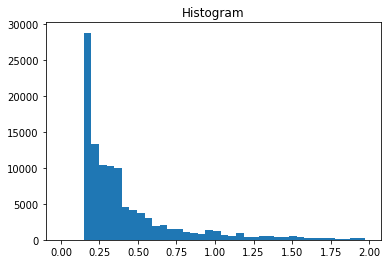

📊 effectiveDuration 📈
mean, std
0.0783763444555
0.150290881665
min
0.0
62348
max
6.16673469543
96037
(0, 0.37895810778619576)


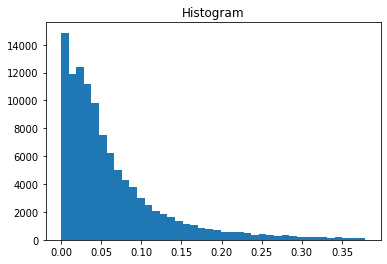

📊 rms 📈
mean, std
7.14133682478e-05
7.46687172601e-05
min
4.12244238746e-10
109159
max
0.000630638794973
83804
(0, 0.00022075080276810202)


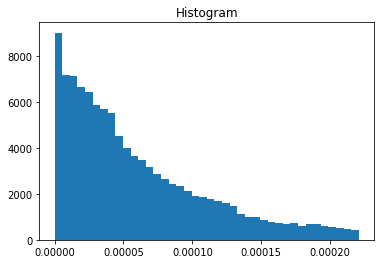

📊 loudness 📈
mean, std
0.000579330164798
0.000814075637878
min
7.81884487711e-11
109159
max
0.00853425543755
83804
(0, 0.0022074814405534534)


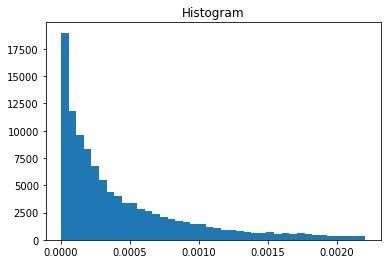

📊 pitch 📈
mean, std
538.883559083
528.8031542
min
0.0
5706
max
3726.21123966
52153
(0, 1596.489867482524)


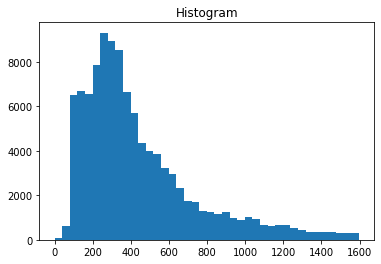

📊 flatness 📈
mean, std
0.335779831264
0.204330031265
min
0.0197589956224
54774
max
1.0
18156
(0, 0.7444398937929988)


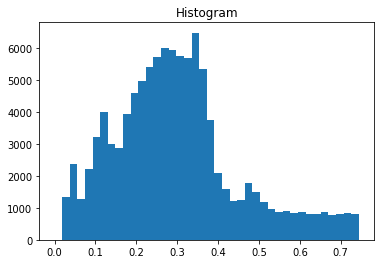

📊 centroid 📈
mean, std
1386.04241838
758.135675364
min
80.7634954439
8779
max
3903.63033075
94102
(0, 2902.3137691127718)


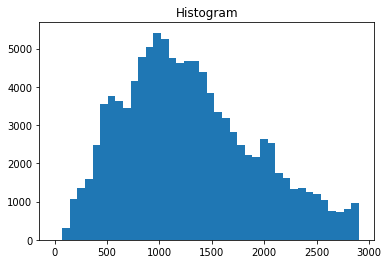

📊 variance 📈
mean, std
3.75130755766e-05
7.8163598565e-05
min
3.91156003394e-15
109126
max
0.00144570821431
28043
(0, 0.00019384027270659746)


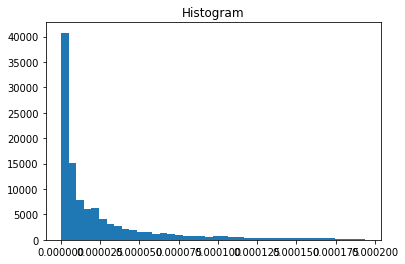

In [40]:
db = create_connection(dbFilename)
db.create_aggregate("stdev", 1, StdevFunc)
db.create_aggregate("histogram", 1, HistogramFunc)

 
def stats(column_name, conn):
    print("📊 %s 📈" % column_name)
    cur = db.cursor()
    cur.execute("select histogram(%s) from sound_objects" %column_name)
    stats_id = cur.fetchone()[0]
    stats_record = (column_name, stats_id)
    update_stats(conn, stats_record)
    
    
delete_stats(db)

stats("durationSeconds", db)
stats("effectiveDuration", db)
stats("rms", db)
stats("loudness", db)
stats("pitch", db)
stats("flatness", db)
stats("centroid", db)
stats("variance", db)
